In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import scanpy as sc
import pyensembl

In [2]:
import data_cleaning as dc
import pathway_encoding as path
import position_encoding as pos
import model as m

In [3]:
ensembl_data = pyensembl.EnsemblRelease(109)
ensembl_data.download()
ensembl_data.index()

adata = sc.read_h5ad('vcc_data/adata_Training.h5ad')
#adata.obs['perturbation_idx'] = np.random.randint(0, CONFIG["n_perturbations"], size=adata.n_obs)
gene_names = pd.read_csv('vcc_data/gene_names.csv')

CONFIG = {
    "n_genes": len(gene_names),
    "n_perturbations": adata.X.shape[0],
    "n_chromosomes": 24,

    "perturbation_dim": 254,      # Condition embedding
    "chrom_embedding_dim": 16,     # Learned in-model for chromosome identity
    "locus_fourier_features": 8,   # Number of Fourier frequency pairs (2*F)
    "pathway_dim": 50,             # From pre-trained Autoencoder(based on hallmark MSigDB)
    "gene_identity_dim": 189,       # Main learnable gene embedding

    # Backbone dims
    "d_model": 512,                # Mamba hidden size
    "mamba_layers": 4,

    # Head
    "prediction_head": "linear", # "linear" | "probabilistic"

    # Training
    "batch_size": 16,
    "learning_rate": 1e-4, # Lowered LR for AdamW stability
    "epochs": 10,
}

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle


--- Starting ADAPTIVE Data Cleanup and Pre-processing ---
Initial shape: 221273 cells x 18080 genes
Step 1 & 2: Calculated and visualizing QC metrics...


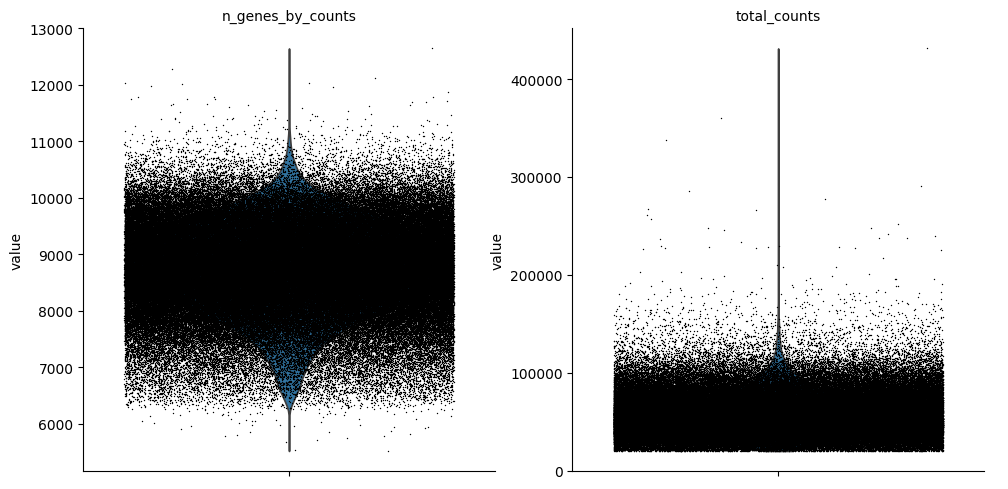


Step 3: Calculating adaptive filtering thresholds...
  - Using min_genes_per_cell: 200
  - Calculated max_genes_per_cell: 10324

Step 4: Applying filters sequentially...
   Filtering complete. Shape is now: 218403 cells x 18010 genes
Step 5: Saved original raw counts to adata.layers['counts']

--- Normalizing and Transforming Data ---
Steps 6 & 7: Normalization and Log1p transformation complete.

--- Pre-processing Complete. ---
--- Precomputing pathway features on control data ---
AE epoch 1/5 | recon MSE: 88.0377
AE epoch 2/5 | recon MSE: 4740.6934
AE epoch 3/5 | recon MSE: 345.8123
AE epoch 4/5 | recon MSE: 276.6099
AE epoch 5/5 | recon MSE: 107.7284
Generated pathway_features shape: torch.Size([18080, 50])

--- Preparing positional indices using pyensembl ---
Increased n_chromosomes to 25 to handle unknown genes.


Fetching gene positions:   0%|          | 1/18079 [00:00<01:30, 200.00it/s]


SUCCESS: Generated positional tensors with shapes:
Chromosome Indices (chr_idx): torch.Size([1])
Normalized Locus (locus_norm): torch.Size([1, 1])
Locus Fourier Features (locus_fourier): torch.Size([1, 16])


ValueError: too many values to unpack (expected 2)

In [4]:

    # Pre-compute Fixed Features (run once, then save/load)
control_adata = dc.get_control_data(adata)
filtered_data = dc.adaptive_clean_and_preprocess_data(adata)
    # find dataset that can represent a nnoramla scell set
pathway_feats = path.precompute_pathway_features(control_adata, CONFIG)
chr_idx, locus_norm = pos.precompute_positional_indices(ensembl_data, gene_names, CONFIG)

    # Instantiate Model, Dataset, Dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
model = m.TranscriptomePredictor(CONFIG, pathway_feats, chr_idx, locus_norm).to(device)
    
dataset = m.PerturbationDataset(adata)
dataloader = DataLoader(dataset, batch_size=CONFIG["batch_size"], shuffle=True)

    # Train
m.train_model(model, dataloader, CONFIG)
